# 3. Meta-Análisis de predicciones y clasificación de riesgo

Este notebook ejecuta la lógica de negocio sobre las predicciones generadas por los modelos de IA.
En lugar de volver a calcular probabilidades (lo cual sería costoso), carga el archivo `analisis_predicciones.csv` generado en la fase de entrenamiento y aplica una "Matriz de decisión" basada en umbrales y tendencias (Deltas).

**Objetivo:** Clasificar cada lectura en una categoría operativa: *No Fuga, Fuga Leve, Fuga Moderada o Fuga Grave*.

## 3.1. Configuración inicial
Importamos las librerías y definimos las rutas y cargamos el CSV de probabilidades asegurando que el formato de fecha sea correcto para poder ordenar temporalmente los eventos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Rutas
INPUT_PREDICTIONS_CSV = '../data/processed-data/analisis_predicciones.csv'
OUTPUT_FILE = '../data/processed-data/incidencias_clasificadas_final.csv'

try:
    # Leemos el CSV generado por el entrenamiento
    df = pd.read_csv(INPUT_PREDICTIONS_CSV, sep=';', decimal=',')
    
    # Convertir fecha para ordenar
    if 'FECHA_HORA_CRONO' in df.columns:
        df['FECHA_HORA_CRONO'] = pd.to_datetime(df['FECHA_HORA_CRONO'])
        df = df.sort_values(by=['POLISSA_SUBM', 'FECHA_HORA_CRONO'])
        
    print(f"Datos cargados: {len(df)} filas.")
    print("Columnas clave:", [c for c in df.columns if 'PROB' in c])
    
except FileNotFoundError:
    print(f"ERROR: No existe {INPUT_PREDICTIONS_CSV}. Ejecuta primero el notebook de entrenamiento.")

Datos cargados: 1811278 filas.
Columnas clave: ['PROB_TARGET_HOY', 'PROB_TARGET_MANANA', 'PROB_TARGET_7DIAS']


## 3.2. Cálculo de deltas (Evolución del riesgo)
Calculamos la "derivada" del riesgo. No nos importa solo si hay fuga hoy, sino si la probabilidad está subiendo o bajando.
- Delta corto: Diferencia entre el riesgo de mañana y el de hoy.
- Delta largo: Diferencia entre el riesgo a 7 días y el de hoy.

In [5]:
# Delta corto: ¿Sube el riesgo mañana? (Pendiente a 24h)
df['DELTA_CORTO'] = df['PROB_TARGET_MANANA'] - df['PROB_TARGET_HOY']

# Delta largo: ¿Sube el riesgo en una semana? (Tendencia estructural)
df['DELTA_LARGO'] = df['PROB_TARGET_7DIAS'] - df['PROB_TARGET_HOY']

# Mostramos un ejemplo para verificar
print(df[['PROB_TARGET_HOY', 'DELTA_CORTO', 'DELTA_LARGO']].head())

   PROB_TARGET_HOY  DELTA_CORTO  DELTA_LARGO
0         0.317676    -0.076205     0.005294
1         0.322249    -0.076483    -0.033005
2         0.333353    -0.088674    -0.057957
3         0.322249    -0.076483    -0.033005
4         0.322105    -0.078684    -0.020369


## 3.3. Aplicación de las reglas de negocio (Semáforo)
Definimos la función `clasificar_fuga` que actúa como un árbol de decisión experto.

Combina la probabilidad actual (¿Es grave ahora?) con los deltas (¿Va a empeorar?) para asignar una etiqueta final.



In [3]:
def clasificar_fuga(row):
    """
    Aplica la Matriz de Decisión para etiquetar la severidad.
    """
    p_hoy = row['PROB_TARGET_HOY']
    delta_corto = row['DELTA_CORTO']
    delta_largo = row['DELTA_LARGO']
    
    # Definición de umbrales
    UMBRAL_SEGURIDAD = 0.30  # Riesgo despreciable
    UMBRAL_ALERTA    = 0.70  # Zona de atención
    UMBRAL_CRITICO   = 0.85  # Fuga casi segura
    
    TENDENCIA_RAPIDA = 0.05  # Crecimiento > 5% en 24h
    TENDENCIA_ESTRUCTURAL = 0.15 # Crecimiento > 15% en 7 días
    
    # 1. ZONA SEGURA
    if p_hoy < UMBRAL_SEGURIDAD:
        return "No Fuga"
    
    # 2. ZONA GRIS (Leve / Falsos positivos potenciales)
    if p_hoy < UMBRAL_ALERTA:
        # Solo alertamos si la tendencia a largo plazo es claramente alcista
        if delta_corto > TENDENCIA_RAPIDA or delta_largo > TENDENCIA_ESTRUCTURAL:
            return "Fuga Leve (Tendencia Creciente)"
        return "No Fuga (Riesgo Bajo)"

    # 3. ZONA DE ALERTA (Moderada vs grave)
    if p_hoy < UMBRAL_CRITICO:
        # Si empeora rápido, escalamos la prioridad a GRAVE aunque la prob. actual no sea crítica
        if delta_corto > TENDENCIA_RAPIDA or delta_largo > TENDENCIA_ESTRUCTURAL:
            return "Fuga Grave (En Crecimiento)"
        return "Fuga Moderada"
    
    # 4. ZONA CRÍTICA
    return "Fuga Grave"

# Aplicamos la lógica a todo el dataset (con barra de progreso)
tqdm.pandas(desc="Clasificando incidencias")
df['ESTADO_FINAL'] = df.progress_apply(clasificar_fuga, axis=1)

Clasificando incidencias: 100%|██████████| 1811278/1811278 [00:20<00:00, 86317.65it/s]


## 3.4. Resultados y visualización del mapa de decisión
Analizamos la distribución de las alertas generadas y visualizamos cómo los umbrales separan las clases.

El gráfico muestra la probabilidad actual (Eje X) vs la tendencia futura (Eje Y), coloreando por la decisión tomada.

ESTADO_FINAL
No Fuga                            39.931363
Fuga Grave                         22.269138
No Fuga (Riesgo Bajo)              21.428130
Fuga Moderada                       8.744599
Fuga Leve (Tendencia Creciente)     6.341600
Fuga Grave (En Crecimiento)         1.285170
Name: proportion, dtype: float64

Archivo clasificado guardado en: ../data/processed-data/incidencias_clasificadas_final.csv


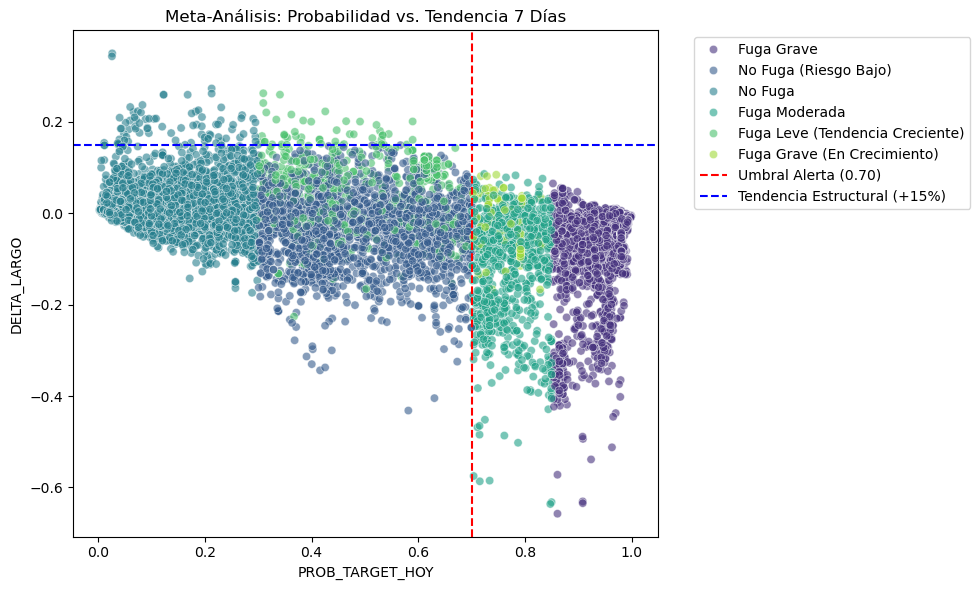

In [4]:
# Resumen de resultados
print(df['ESTADO_FINAL'].value_counts(normalize=True) * 100)

# Guardar resultado final
df.to_csv(OUTPUT_FILE, index=False, sep=';', decimal=',')
print(f"\nArchivo clasificado guardado en: {OUTPUT_FILE}")

# Visualización (Scatterplot)
plt.figure(figsize=(10, 6))

# Usamos una muestra aleatoria para que el gráfico sea legible y rápido
sample_plot = df.sample(n=min(10000, len(df)), random_state=42)

sns.scatterplot(
    data=sample_plot, 
    x='PROB_TARGET_HOY', 
    y='DELTA_LARGO', 
    hue='ESTADO_FINAL', 
    alpha=0.6, 
    palette='viridis' 
)

# Dibujamos las líneas de corte (Umbrales)
plt.title('Meta-Análisis: Probabilidad vs. Tendencia 7 Días')
plt.axvline(0.70, color='red', linestyle='--', label='Umbral Alerta (0.70)')
plt.axhline(0.15, color='blue', linestyle='--', label='Tendencia Estructural (+15%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()